# Framingham Heart Disease Risk Study
 ## Exploratory Data Analysis

## 1. Sourcing and loading

### 1.1 Import libraries

In [1]:
# Working with data
import numpy as np
import pandas as pd

# Visualization and exploration
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from pca import pca

# Modeling
import statsmodels.api as sm
from sklearn import linear_model
from sklearn import preprocessing, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# QOL things
# !pip install tqdm
from tqdm.notebook import tqdm # Progress bar
tqdm.set_lock(None)  # Disable thread locking to prevent issues in Jupyter notebooks

# Custom functions
from functions import grid_plots, ecdf, get_function_code, sb_utils

### 1.2 Load data

In [2]:
df_clean_path = '../data/interim/data_clean.csv'
df_winsorized_path = '../data/interim/data_winsorized.csv'

df_clean = pd.read_csv(df_clean_path)
df_winsorized = pd.read_csv(df_winsorized_path)

### 1.3 Exploring data

In [3]:
df_clean.shape, df_winsorized.shape

((3189, 19), (3189, 19))

As a disclaimer, the 'data_clean' and 'data_winsorized' are practically the same data sets, but within the winsorized data all the extreme outliers were winsorized to fit within the range of (Q1 - 1.5*IQR) and (Q3 + 1.5*IQR). So it will make sense to focus on just 'df_clean' data set for now, and keep the 'df_winsorized' for the future model evaluations.

In [4]:
df = df_clean
df.head()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD,MAP,hypertension_calc
0,1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0,121.33,1
1,2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0,86.00,0
2,3,50,1.0,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1,111.33,1
3,4,64,1.0,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0,102.17,0
4,5,61,3.0,0,0,0.0,0.0,0,1,0,272.0,182.0,121.0,32.80,85.0,65.0,1,141.33,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3189 entries, 0 to 3188
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 3189 non-null   int64  
 1   age                3189 non-null   int64  
 2   education          3189 non-null   float64
 3   sex                3189 non-null   int64  
 4   is_smoking         3189 non-null   int64  
 5   cigsPerDay         3189 non-null   float64
 6   BPMeds             3189 non-null   float64
 7   prevalentStroke    3189 non-null   int64  
 8   prevalentHyp       3189 non-null   int64  
 9   diabetes           3189 non-null   int64  
 10  totChol            3189 non-null   float64
 11  sysBP              3189 non-null   float64
 12  diaBP              3189 non-null   float64
 13  BMI                3189 non-null   float64
 14  heartRate          3189 non-null   float64
 15  glucose            2927 non-null   float64
 16  TenYearCHD         3189 

#### Column definitions:
* id: (unique)
    * id of a patient 
* age: (continuous)
    * Age of the patient 
* education: (ordinal)
    1. Some high school
    2. High school diploma
    3. Some college or vocational training
    4. College degree or higher
* sex: (nominal)
    * 0 for female
    * 1 for male
* is_smoking: (nominal)
    * 1 for smoker
    * 0 for non-smoker
* cigsPerDay: (continuous)
    * Number of cigarettes smoked each day
* BPMeds: (nominal)
    * 1 if patient takes anti-hypertension medications
    * 0 if patient does not take anti-hypertension medications
* prevalentStroke: (nominal)
    * 1 if patient previously had stroke
    * 0 if patient did not have stroke in the past
* prevalentHyp: (nominal)
    * 1 if patient previously had diagnosed hypertension
    * 0 if patient did not have hypertension in the past
* diabetes: (nominal)
    * 1 if patient has diabetes
    * 0 if patient does not have diabetes
* totChol: (continuous)
    * Total cholesterol concentration (mg/dl)
* sysBP: (continuous)
    * Systolic blood pressure (mmHg)
* diaBP: (continuous)
    * Diastolic blood pressure (mmHg)
* BMI: (continuous)
    * Body Mass Index
* heartRate: (continuous)
    * Heart Rate (bpm)
* glucose: (continuous)
    * Blood glucose concentration (mg/dl)
* TenYearCHD: (nominal) ----> Target
    * 1 if patient has 10 year risk of coronary heart disease (CHD)
    * 0 if patient has no 10 year CHD risk
* MAP: (continuous)
    * Mean arterial pressure, calculated in previous step
* hypertension_calc: (nominal)
    * Hypertension diagnosis, calculated based on the MAP value in previous step

All columns are of an appropriate data types.
Let's see if we can make an index out of the 'id' column, because it seems like it's just mirroring the index.

In [6]:
df.id.nunique()

3189

In [7]:
df['id'].equals(pd.Series(range(1, len(df) + 1)))

False

As expected, 'id' is not a sequence of integers incrementing by one, because we dropped some columns from the original data set. Although this column provides no value to the case, we dropped the same exact columns in the 'df_winsorized', so such integrity may be useful in future.

Let's explore the target value 'TenYearCHD' 

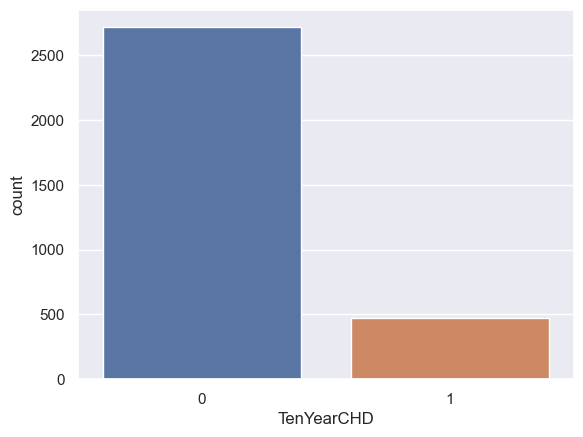

In [8]:
sns.countplot(data=df, x='TenYearCHD');

In [9]:
df[df['TenYearCHD'] == 0]['TenYearCHD'].count() / df[df['TenYearCHD'] == 1]['TenYearCHD'].count()
# ['TenYearCHD'].sum() / df.shape[0]

5.713684210526316

There is an imbalance within our target value with ratio of 5.7 / 1 (No Risk / Risk). We might need to balance this in future and compare model performance.

Let's visualize our columns. Starting with categorical values.

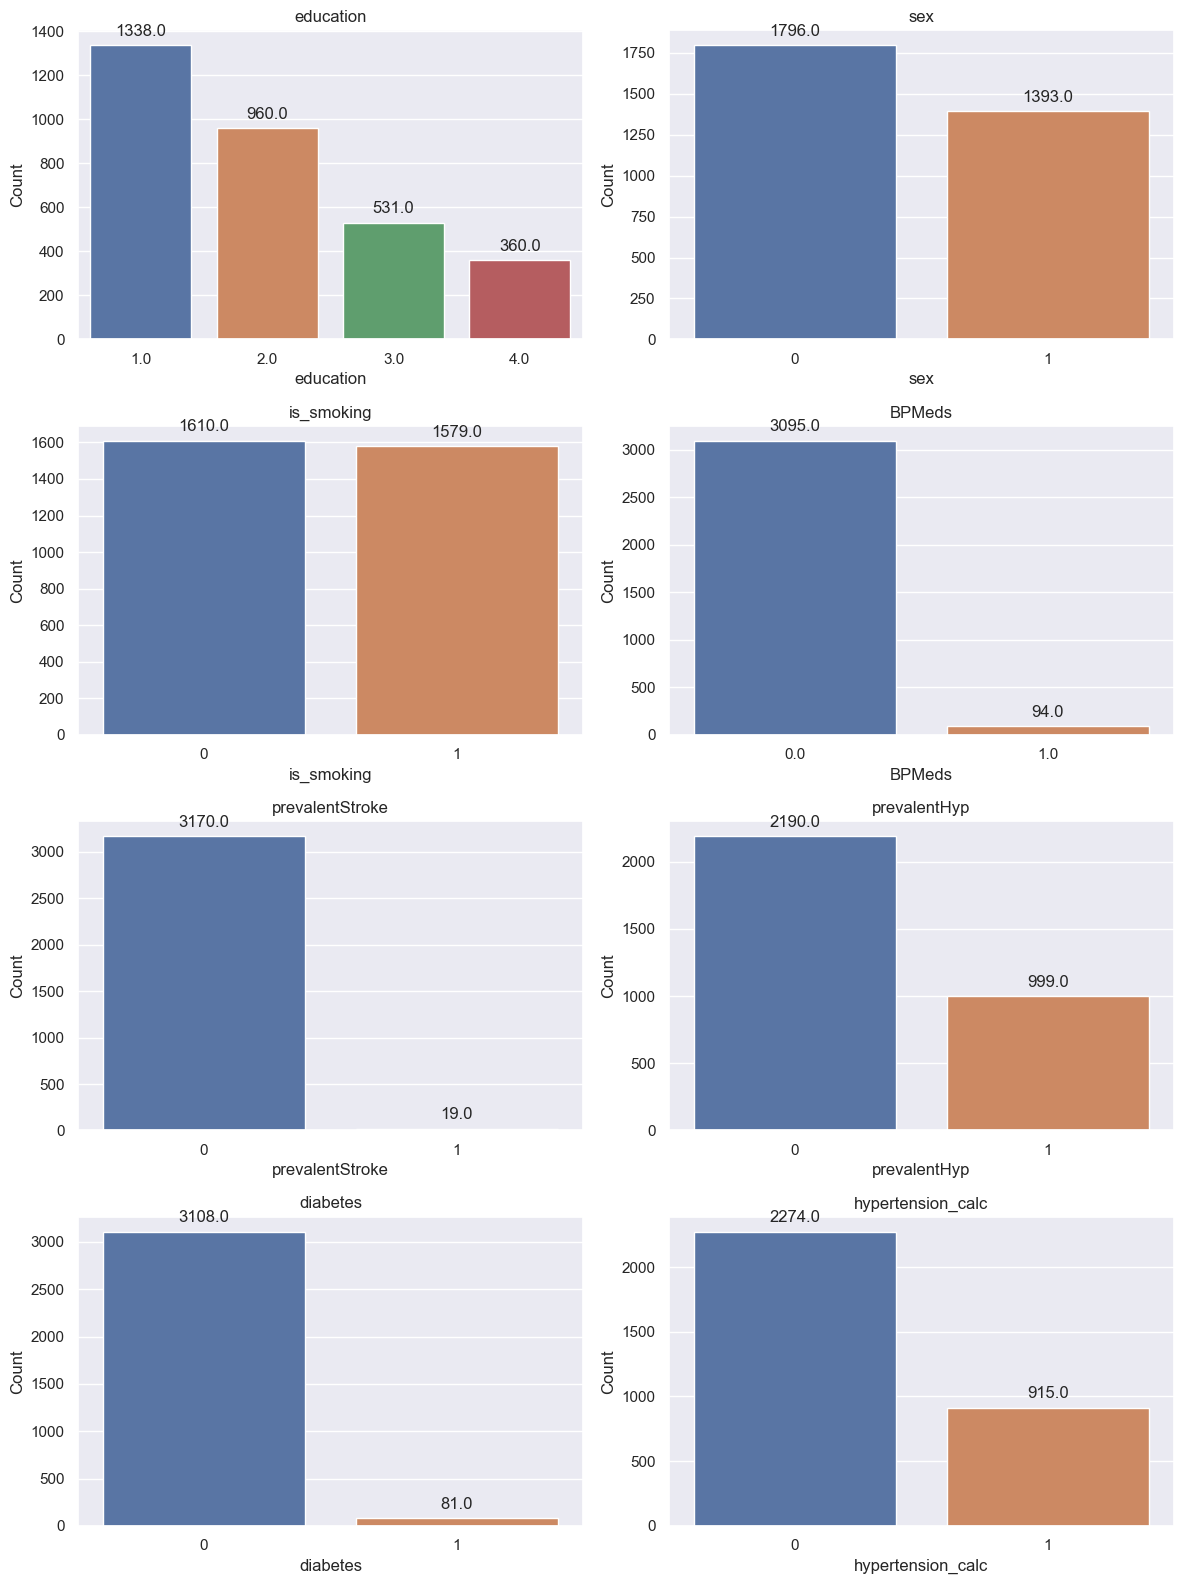

In [10]:
categorical_cols = ['education', 'sex', 'is_smoking', 'BPMeds', 'prevalentStroke', 'prevalentHyp', 'diabetes', 'hypertension_calc']
grid_plots.plot_grid_bar(df, categorical_cols)

We can see that out of all categorical columns the most balanced are 'sex' and 'is_smoking'. 
Education column shows the expected distribution of education levels.
Prevalent hypertension column shows that approximately 1/3 of all patients have diagnosis of hypertension, but only 94! out of them take any blood pressure medications. Compared to the column 'hypertension_calc' that was calculated in previous step, there is not much difference in the diagnosed hypertension distribution.
We will do the same with the diabetes column, comparing it with the blood sugar levels, because there are only 81 patients with established diagnosis of diabetes.
Prevalent stroke column (with only 19 positive patients) cannot be compared with any other column. Although we can look if it's more prevalent in elderly patients, and if this column is of any use.

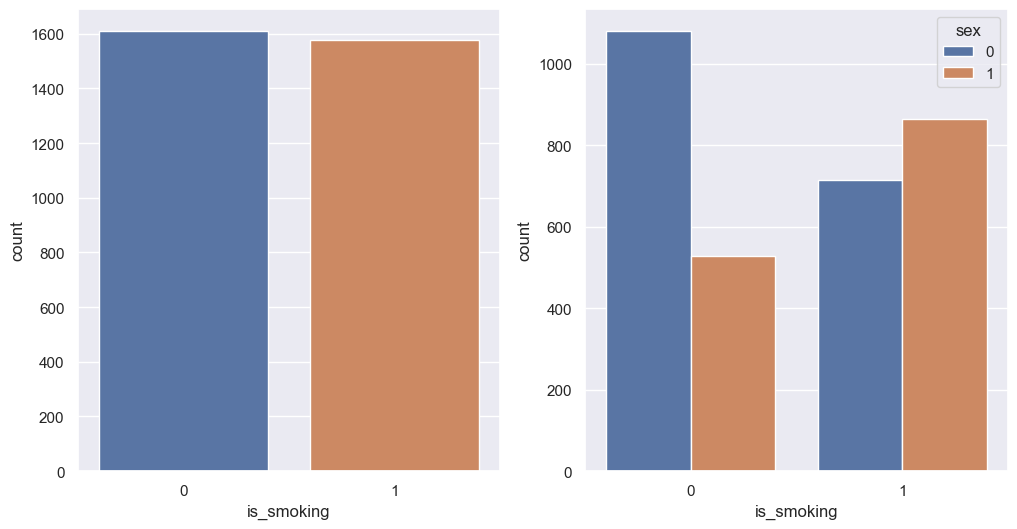

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# Plot of smokers
sns.countplot(data=df, x='is_smoking', ax=ax[0])

# Plot of smokers by age
sns.countplot(data=df, x='is_smoking', hue='sex', ax=ax[1]);


There are more men among smokers. Out of curiosity let's see how education related with smoking status in the 1970s.

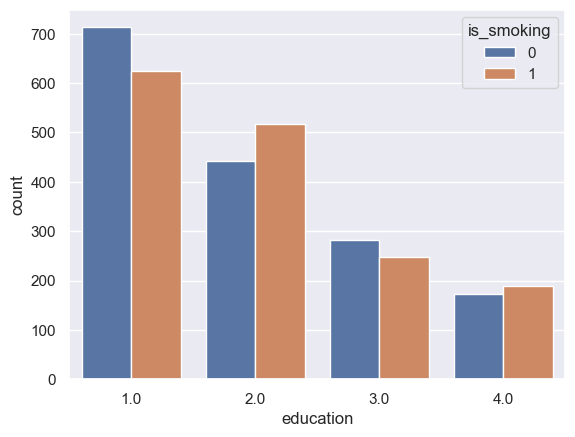

In [12]:
sns.countplot(data=df, x='education', hue='is_smoking');

That's interesting! The largest portion of non-smokers within an education level group is within level 1. Then level 2 shows the opposite, with smokers being more prevalent. Level 3 shows similar ratio as level 1. And there are slightly more smokers than non-smokers in the level 4 group. Could this be related to some other factors?

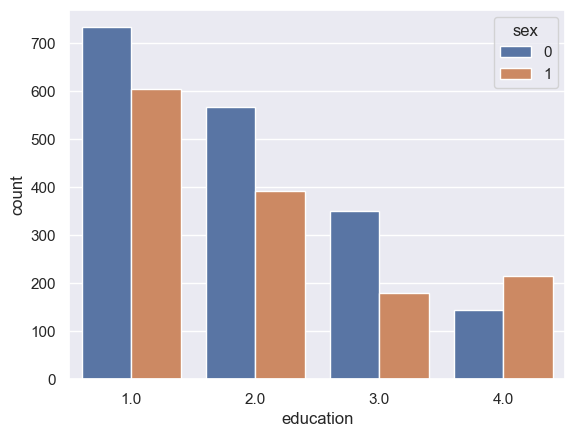

In [13]:
sns.countplot(data=df, x='education', hue='sex');

It seems like women are more prevalent in level 1-3 education groups, with 2/1 ratio within the level 3 group. 
Comparing absolute values within the groups make an impression that almost all smokers within level 1 are men (~700), but can we say that there is an influence within other groups, let's check.

In [14]:
# for e in sorted(list(df['education'].unique())):
#     for s in df['sex'].unique():
#         print(f'Education {e}, sex     {s}: {df.loc[df["education"] == e].loc[df["sex"] == s].shape[0]}')
#     for smok in df['sex'].unique():
#         print(f'Education {e}, smoking {s}: {df.loc[df["education"] == e].loc[df["is_smoking"] == smok].shape[0]}')
#     print('\n')


for e in sorted(list(df['education'].unique())):
    print(f'\nEducation {e:.0f}:')
    for sex, smok in zip(df['sex'].unique(),df['sex'].unique()):
        print(f'\tSmoking {smok}: {df.loc[df["education"] == e].loc[df["is_smoking"] == smok].shape[0]}')
        print(f'\tSex     {sex}: {df.loc[df["education"] == e].loc[df["sex"] == sex].shape[0]}')



Education 1:
	Smoking 1: 625
	Sex     1: 605
	Smoking 0: 713
	Sex     0: 733

Education 2:
	Smoking 1: 518
	Sex     1: 393
	Smoking 0: 442
	Sex     0: 567

Education 3:
	Smoking 1: 248
	Sex     1: 180
	Smoking 0: 283
	Sex     0: 351

Education 4:
	Smoking 1: 188
	Sex     1: 215
	Smoking 0: 172
	Sex     0: 145


As predicted values within education level 1 are almost identical. Level 2 is very interesting. The rest are just not that extreme.

Let's start to mix in some of the continuous variables.
I want to see if there is any pattern in age-sex distribution.

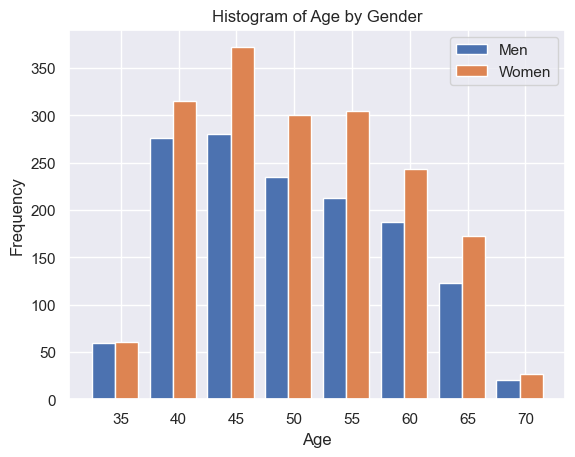

In [15]:
# # Separate data for men and women
men_data = df[df['sex'] == 1]['age']
women_data = df[df['sex'] == 0]['age']

# Set the bin width
bin_width = 5

# Plot the histogram
plt.hist([men_data, women_data], bins=range(min(df['age']), max(df['age']) + bin_width, bin_width),label=['Men', 'Women'])

# Add labels and title
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Histogram of Age by Gender')
plt.legend()

# Show the plot
plt.show()

As was shown at the sex count plot, women are just more prevalent in this data in general.

In [16]:
# List of continuous features
continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'MAP', 'BMI', 'heartRate', 'glucose']

# Describe continuous features
df[continuous_cols].describe()
df.columns

Index(['id', 'age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD', 'MAP',
       'hypertension_calc'],
      dtype='object')

Let's introduce new column with a diagnosis of Diabetes, which we will calculate based on the levels of blood glucose. Similar to how it was done in previous notebook for the blood pressure.

In [17]:
# Assuming that fasting blood glucose level needed to diagnose Diabetes is at least 126 mg/dL, create a column with 1 or 0 for diabetes diagnosis. (We are making approximation heer, as the gold standard for DM diagnosis is two separate tests, oral glucose tolerance test or HbA1c test).

# Function to create diabetes_calc column based on 'glucose' level
def classify_col_1_0(data, cont_col, class_col, cutoff):
    data[class_col] = 0
    data.loc[data[cont_col] >= cutoff, class_col] = 1

In [18]:
# Call function and compare columns
classify_col_1_0(data=df, 
                cont_col='glucose',
                class_col='diabetes_1_0',
                cutoff=126)

print(f'Diabetes from original data: {df["diabetes"].value_counts()[0]}\n'
        f'Diabetes calculated in new set: {df["diabetes_1_0"].value_counts()[0]}')

Diabetes from original data: 3108
Diabetes calculated in new set: 3124


Well, not much of a difference. Only few people were not diagnosed with Diabetes.

### Continuous variables
Let's see the distributions of the continuous variables now.

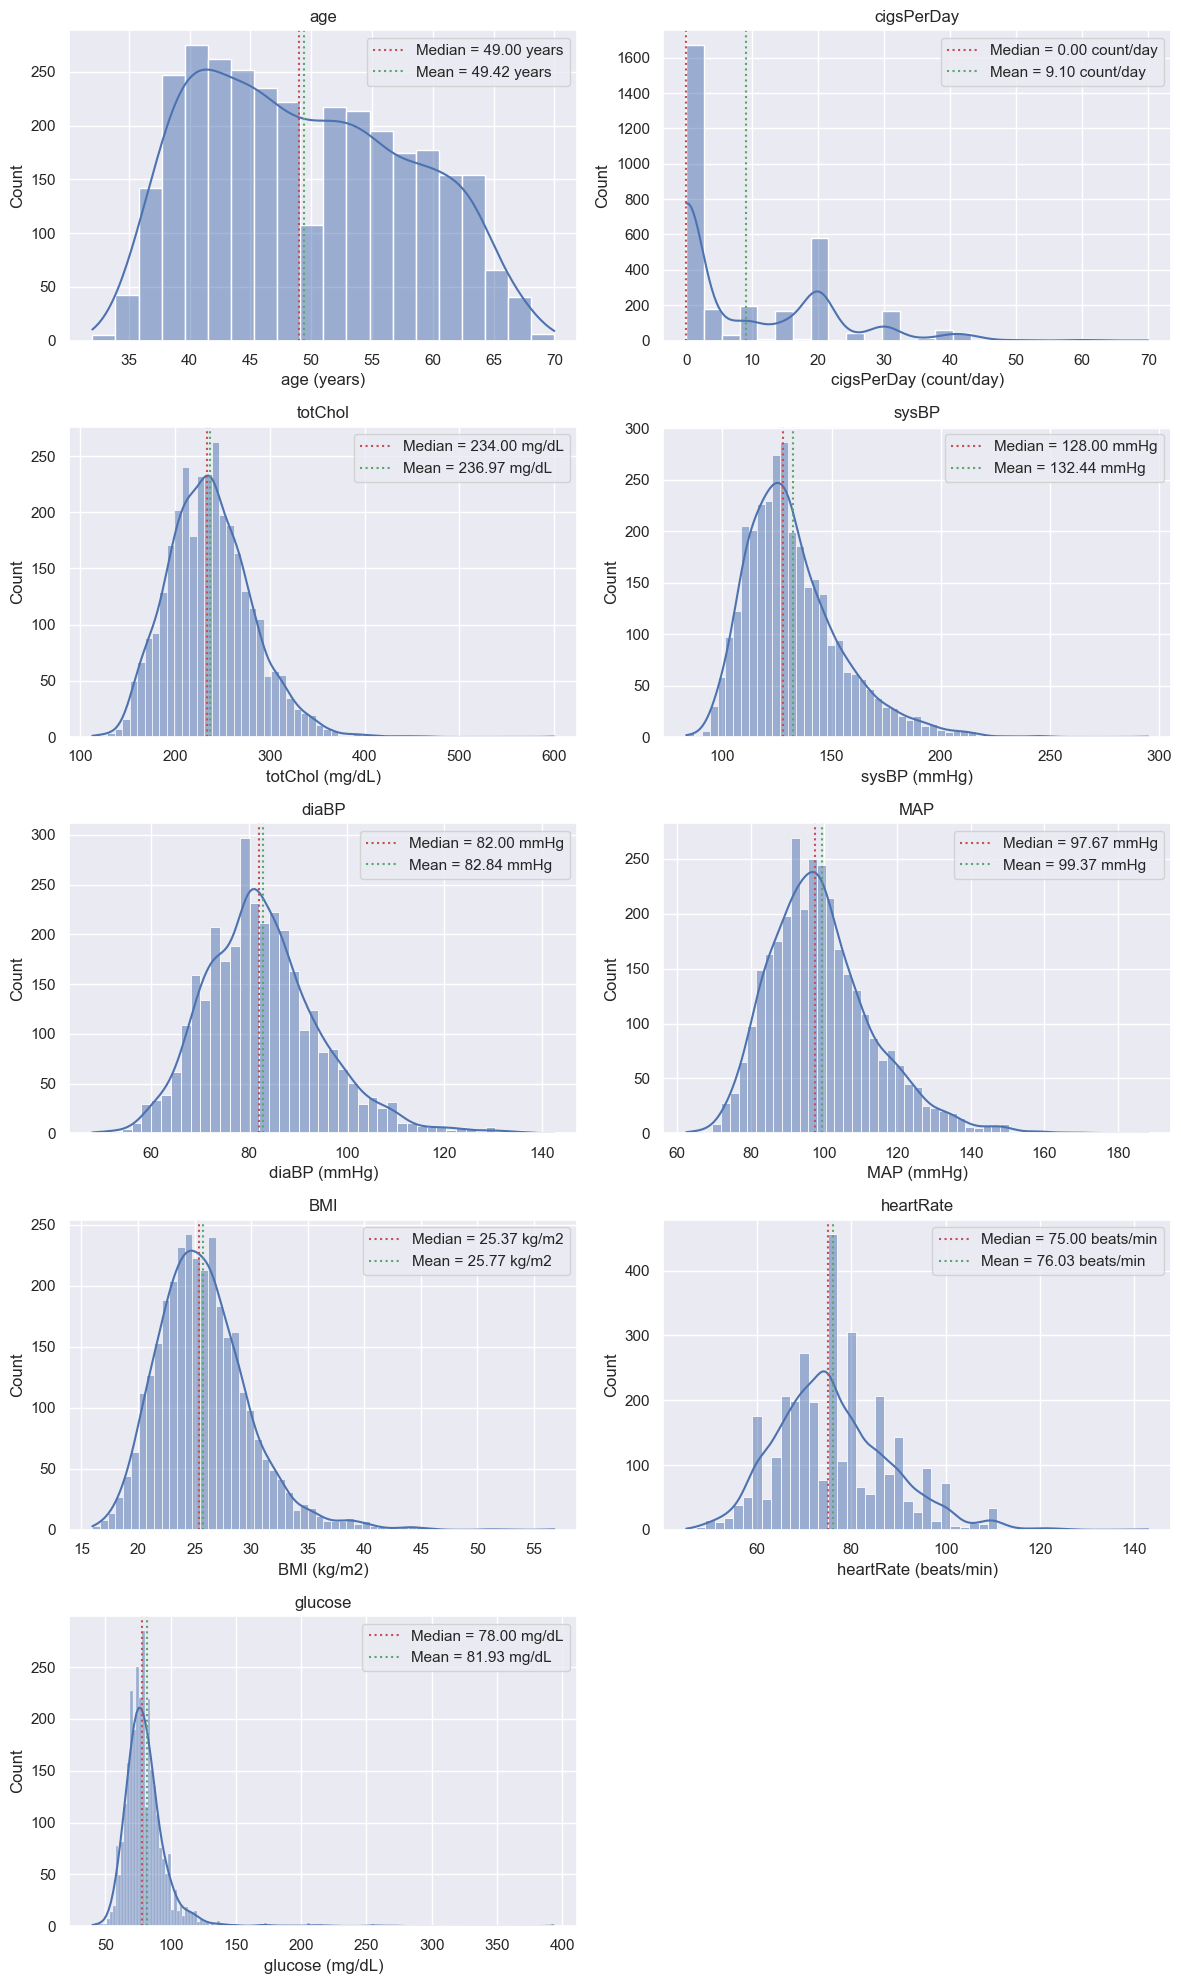

In [19]:
# List of continuous features
continuous_cols = ['age', 'cigsPerDay', 'totChol', 'sysBP', 'diaBP', 'MAP', 'BMI', 'heartRate', 'glucose']

# List of units for these continuous variables
unit_list = ['years', 'count/day', 'mg/dL', 'mmHg', 'mmHg', 'mmHg', 'kg/m2', 'beats/min', 'mg/dL']

# Call a function from the functions library that will plot distributions in a grid
grid_plots.plot_grid_displots(df, continuous_cols, unit_list)

Age: There is a weird drop in the middle of the histogram for the age at around 50 years old. This may be due to the binning. Let's try to plot all age values in the dataset.

In [20]:
# Check if ages are incremented by 1
age_not_inc = (df['age'].sort_values(ascending=True).unique() != pd.Series(range(32, 71))).any()
print("Ages are incremented by 1 from 32 to 70.") if not age_not_inc else print("Ages are NOT incremented by 1 from 32 to 70.")

# print(df['age'].sort_values(ascending=True).unique())

Ages are incremented by 1 from 32 to 70.


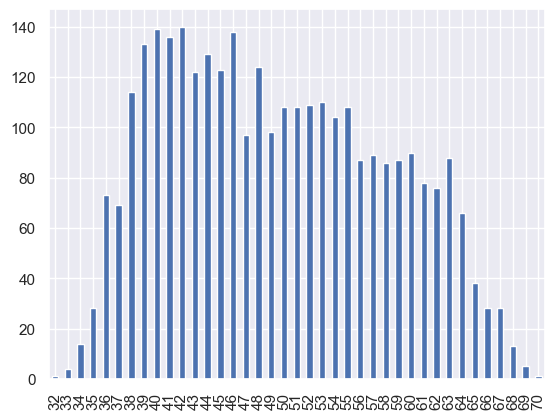

In [21]:
# Plot all unique age value counts
df['age'].value_counts().sort_index().plot(kind='bar');

There is nothing unusual about distribution of ages.

All these plots except 'cigs_per_day' have pretty much a bell shape, with mean and median pretty close to each other. However, there are distinct right tails of the distributions. Let's check how normal these distributions are via plotting their ECDFs.

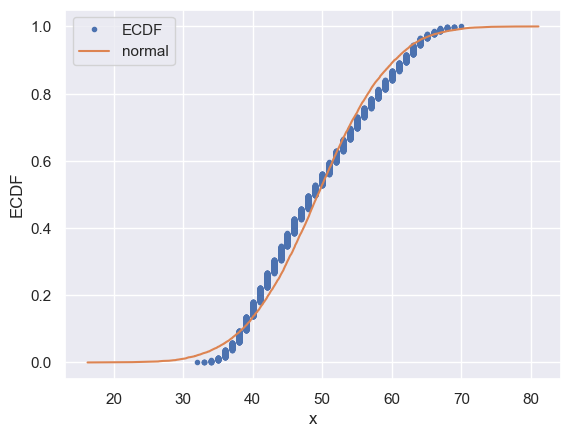

In [22]:
# Use the custom ecdf function to plot ECDF of the continuous variables.
ecdf.plot_ecdf_overlay(df['age'], overlay='normal')

Age distribution seems to deviate slightly from the normal.

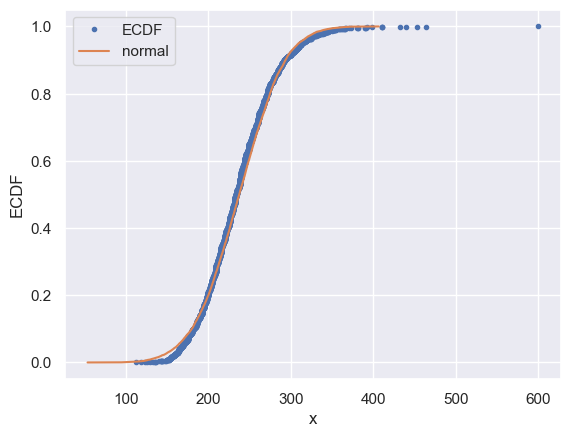

In [23]:
ecdf.plot_ecdf_overlay(df['totChol'], overlay='normal')

Total cholesterol is almost normally distributed.

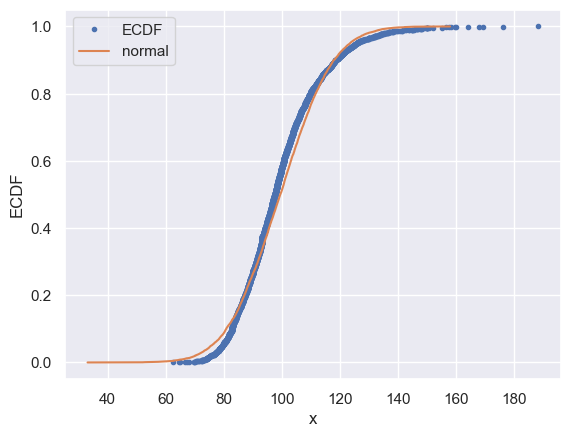

In [24]:
ecdf.plot_ecdf_overlay(df['MAP'], overlay='normal')

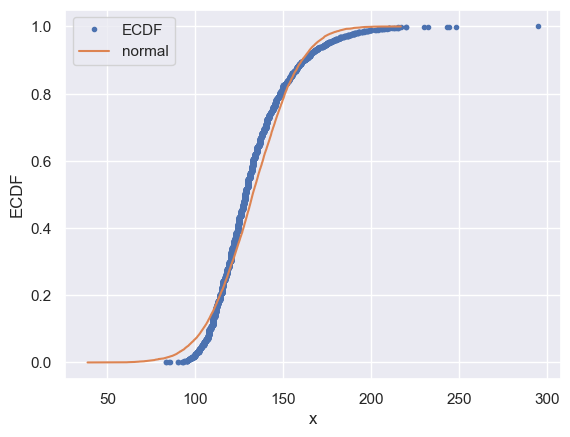

In [25]:
ecdf.plot_ecdf_overlay(df['sysBP'], overlay='normal')

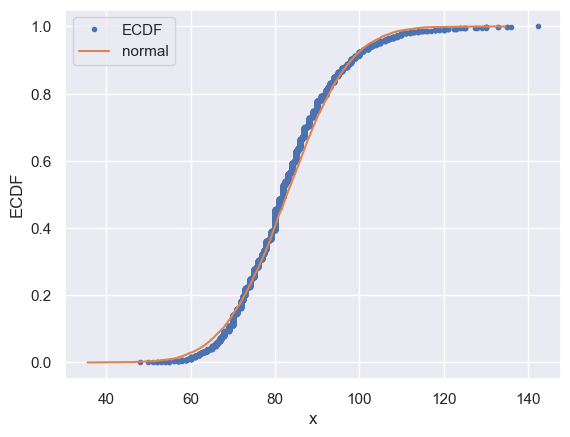

In [26]:
ecdf.plot_ecdf_overlay(df['diaBP'], overlay='normal')

Out of the blood pressure columns the most normally distributed is MAP (that we engineered based on Sys and Dia BP).

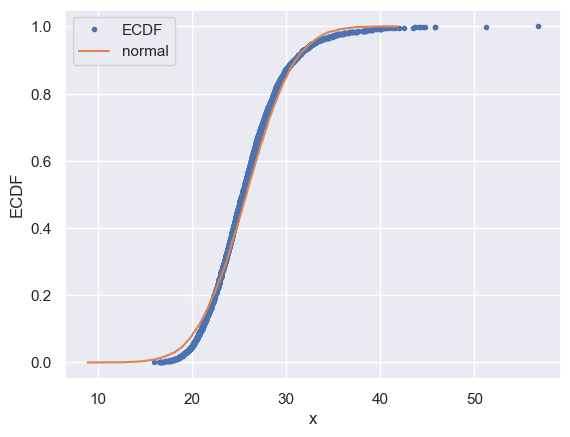

In [27]:
# ecdf.plot_ecdf_overlay(df[df['cigsPerDay'] > 0]['cigsPerDay'], overlay='normal')
ecdf.plot_ecdf_overlay(df['BMI'], overlay='normal')

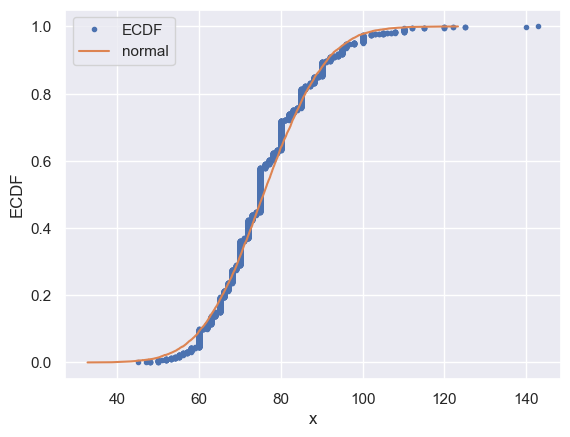

In [28]:
ecdf.plot_ecdf_overlay(df['heartRate'], overlay='normal')

These are pretty much normal.

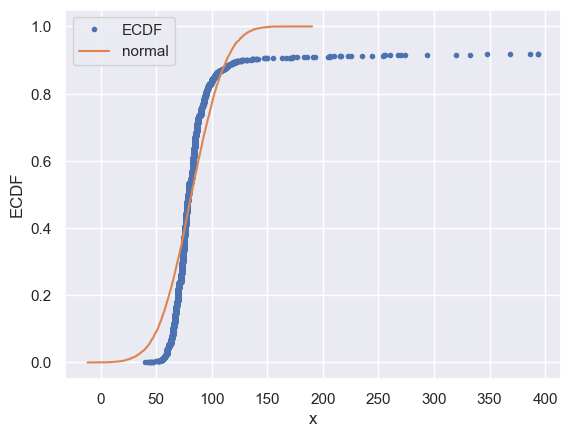

In [29]:
ecdf.plot_ecdf_overlay(df['glucose'], overlay='normal')

Glucose does very poorly in normality of its distribution. This is mainly due to the abundance of extreme outliers on the right. Out of curiosity let's check this column from the df_winsorized dataset.

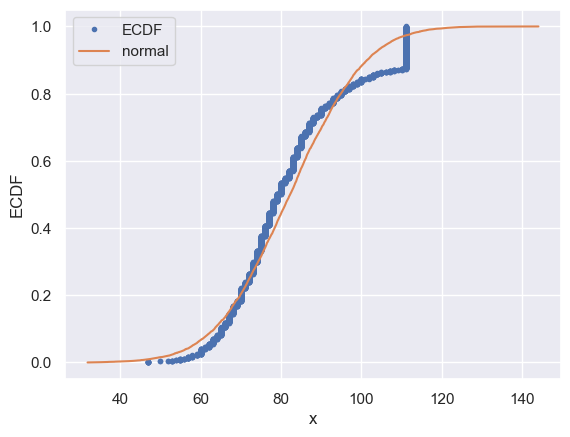

In [30]:
ecdf.plot_ecdf_overlay(df_winsorized['glucose'], overlay='normal')

As can be seen there are outliers that are winsorized. Overall this may not be the best approach, but we'll see model's performance later.
Also, out of curiosity, let's try to plot ECDF for the dataset with these outliers dropped altogether.

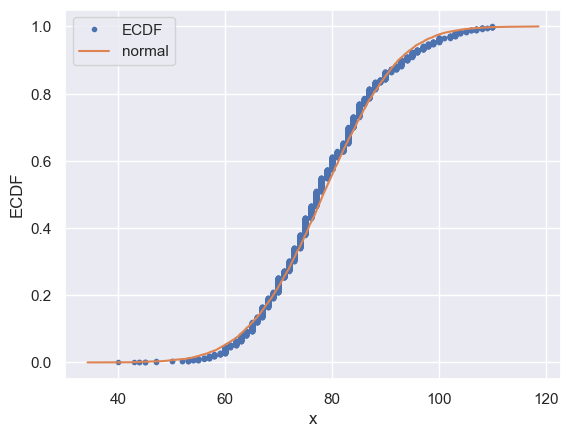

In [31]:
ecdf.plot_ecdf_overlay(df.loc[df_winsorized['glucose'] < df_winsorized['glucose'].max()]['glucose'], overlay='normal')

Here we can see that data without outliers is normally distributed. So, dropping all of the outliers may be a viable approach for model training. Alternatively we can impute missing values with mean, median or KNN.

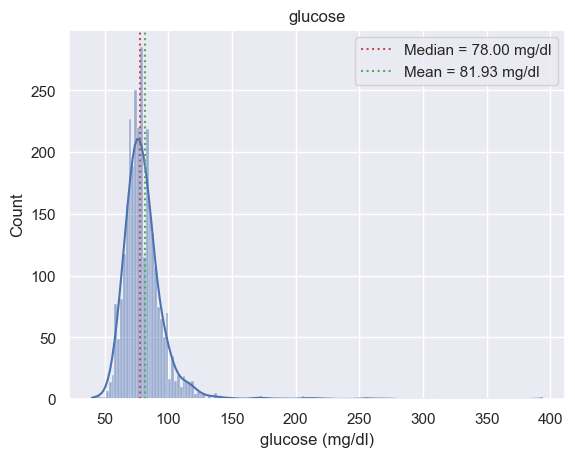

In [36]:
# Preview glucose distribution once again.
fig, ax = plt.subplots()
sns.histplot(data=df, x='glucose', kde=True)
ax.set_title('glucose')
ax.set_xlabel(f'glucose (mg/dl)')
ax.set_ylabel(f'Count')

# Add vertical lines for median and mean
median = df['glucose'].median()
mean = df['glucose'].mean()
ax.axvline(median, color='r', linestyle='dotted',
                        label=f'Median = {median:.2f} mg/dl')
ax.axvline(mean, color='g', linestyle='dotted',
                        label=f'Mean = {mean:.2f} mg/dl')

ax.legend()
plt.show()

In [37]:
df['glucose'].isna().sum()

262

There are 262 missing values in the glucose column.
The mean of this distribution is higher than median, so we can try to impute missing values with median.